In [85]:
from pathlib import Path
from glob import glob
from copy import copy
from itertools import permutations
import json

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from NegativeClassOptimization import config, ml, preprocessing, datasets, utils
from utils_07 import get_miniabsolut_dataframes, task_generator
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [86]:
config.DATA_BASE_PATH

task_types = (
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

In [87]:
def create_task(task_type, ag):
    task = datasets.ClassificationTask(
        task_type=task_type,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    return task

def get_attr_aa(task_attributions):
    attr_stack = get_attr_from_records(
        task_attributions, attributor_name, (0, 1)  # type: ignore
    )  # Nx11x20
    onehot_stack = get_onehotstack_from_records(
        task_attributions, (0, 1)  # type: ignore
    )  # Nx220
    attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(
        -1, 11
    )  # Nx11
    return attr_aa

In [108]:
#will delete later
from collections import Counter
def shannon_entropy(sequence):
    """Calculate Shannon entropy for a protein sequence."""
    counts = Counter(sequence)  # Count occurrences of each amino acid
    total_length = len(sequence)
    probabilities = [count / total_length for count in counts.values()]  # Compute probabilities
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)  # Compute entropy
    return entropy

In [ ]:
#need to delete
res = []
for task_type in task_types:
    for ag in config.ANTIGENS:
        task = create_task(task_type, ag)
        df_eng = get_miniabsolut_dataframes(task, load_energy_contributions=False)
        train_obj =loader.load(task,load_model=False,load_test_dataset=False, load_train_dataset=True,\
            load_zscores=False,)
        df_train_neg = train_obj.train_dataset.query('binds_a_pos_ag == 0').copy()
        df_train_neg['shannon_entr'] = df_train_neg.apply(lambda x: shannon_entropy(x['Slide']), axis=1)
        df_train_neg['ag'] = ag
        df_train_neg['task_type'] = task_type.name
        res.append(df_train_neg[['ag', 'task_type', 'shannon_entr']])
df = pd.concat(res)

<Axes: xlabel='ag', ylabel='shannon_entr'>

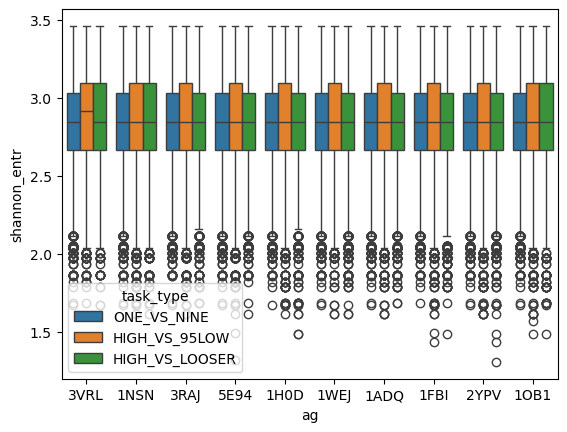

In [ ]:
#need to delete
sns.boxplot(data=df, x='ag', y='shannon_entr', hue='task_type')
# i think i need to do PWMs and then measure their shannon entropy

In [6]:
force_run = False
if force_run:
    attributor_name = "DeepLIFT_LOCAL_v2.0-2"
    for task_type in task_types:
        for ag in config.ANTIGENS:
            task = create_task(task_type, ag)

            #loading energies
            df_energy = get_miniabsolut_dataframes(task, load_energy_contributions=True)
            df_energy['energies'] = df_energy.contribPerAAparaBind.apply(utils.extract_contributions_from_string)
            df_energy['energies_fold'] = df_energy.contribPerAAparaFold.apply(utils.extract_contributions_from_string)
            df_energy['energies_total'] = df_energy['energies'].apply(np.array) + df_energy['energies_fold'].apply(np.array)
            df_energy = df_energy[['Slide', 'energies', 'energies_fold', 'energies_total']]

            #loading attributions
            attr_records =loader.load(task,load_model=False,load_test_dataset=True, load_train_dataset=False,\
            attributions_toload='v2.0-2',attribution_records_toload="attribution_records.json",load_zscores=False,)
            df_attr = pd.DataFrame(attr_records.attributions)
            df_attr['attr_aa'] = get_attr_aa(attr_records.attributions).tolist()

            #merging
            df_attr_energy = df_attr.merge(df_energy, left_on='slide', right_on='Slide')

            df_attr_energy['energies_total_norm'] = df_attr_energy.energies_total.apply(lambda x: x[1] / np.linalg.norm(x[1]))    
            df_attr_energy['attr_aa_norm'] = df_attr_energy.attr_aa.apply(lambda x: x / np.linalg.norm(x))
            df_attr_energy["r_total"] = df_attr_energy.apply(lambda x: pearsonr(x["attr_aa_norm"], x["energies_total_norm"])[0], axis=1)

            df_attr_energy.to_pickle(f"../data/energy_attr_corr/{task_type.name}_{ag}_energy_attr.pkl")
        


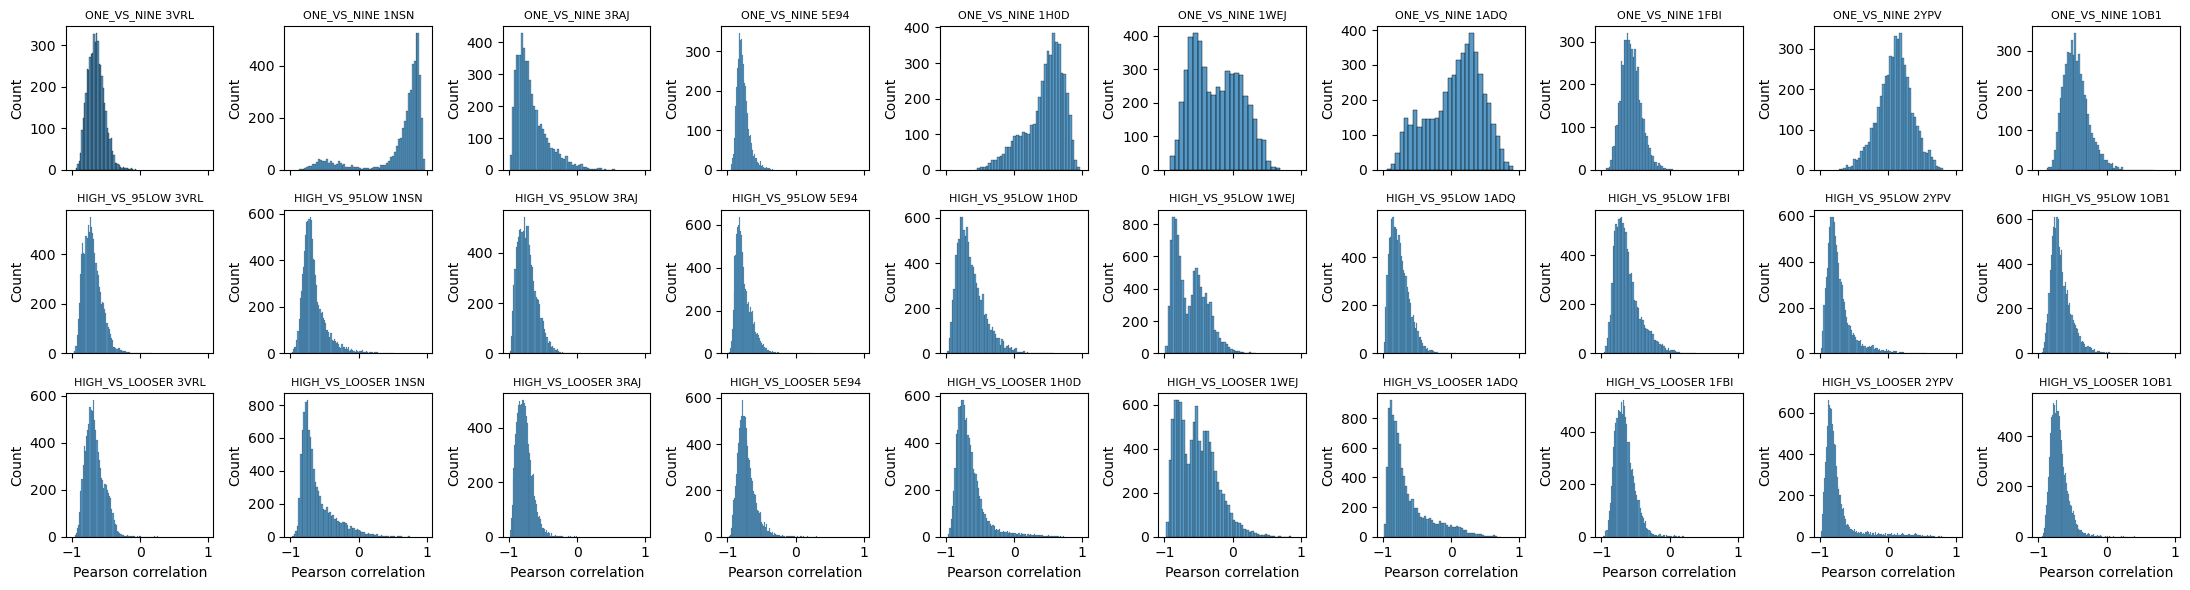

In [7]:
fig, ax = plt.subplots(3,10, figsize=(22,6), sharex=True)
for i, task in enumerate(task_types):
    for j, ag in enumerate(config.ANTIGENS):
        df = pd.read_pickle(f"../data/energy_attr_corr/{task.name}_{ag}_energy_attr.pkl")
        sns.histplot(df["r_total"], ax = ax[i,j])
        ax[i,j].set_title(f"{task.name} {ag}", fontsize=8)
        # name only last row x-axis
        if i == 2:
            ax[i,j].set_xlabel("Pearson correlation")
        else:
            ax[i,j].set_xlabel("")
plt.tight_layout()

In [ ]:
#do scatterplot from the abbove, find mean or mode

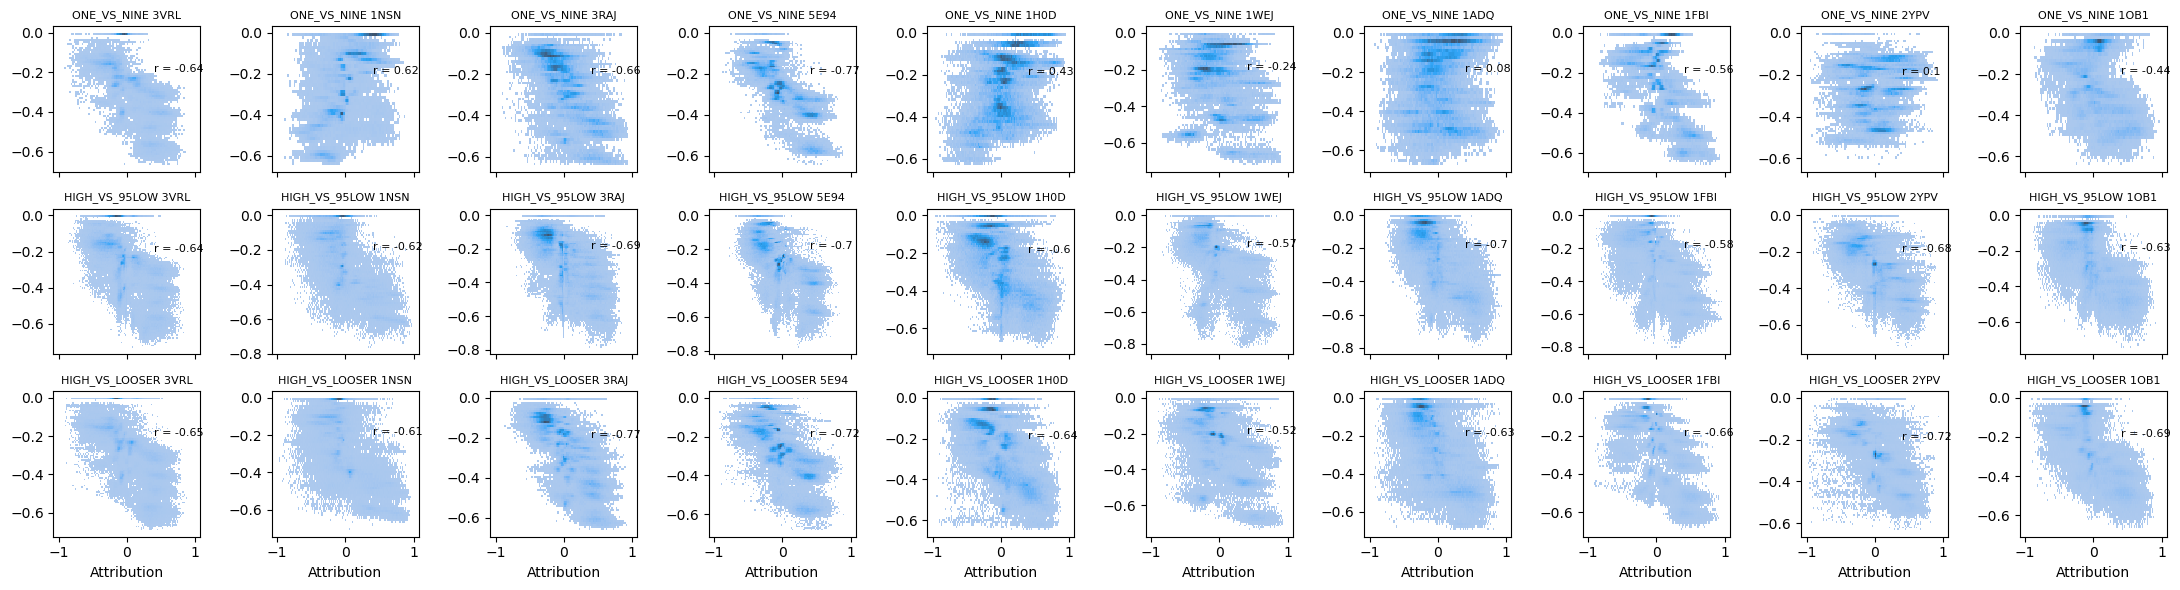

In [8]:
fig, ax = plt.subplots(3,10, figsize=(22,6), sharex=True)
for i, task in enumerate(task_types):
    for j, ag in enumerate(config.ANTIGENS):
        df = pd.read_pickle(f"../data/energy_attr_corr/{task.name}_{ag}_energy_attr.pkl")
        x_values = np.concatenate(df['attr_aa_norm'].to_numpy())
        y_values = np.concatenate(df['energies_total_norm'].to_numpy())
        sns.histplot(x = x_values, y = y_values, ax=ax[i,j])
        #
        ax[i,j].text(0.4, -0.2, f"r = {round(pearsonr(x_values, y_values)[0], 2)}", fontsize=8)
        ax[i,j].set_title(f"{task.name} {ag}", fontsize=8)
        # name only last row x-axis
        if i == 2:
            ax[i,j].set_xlabel("Attribution")
        else:
            ax[i,j].set_xlabel("")
plt.tight_layout()

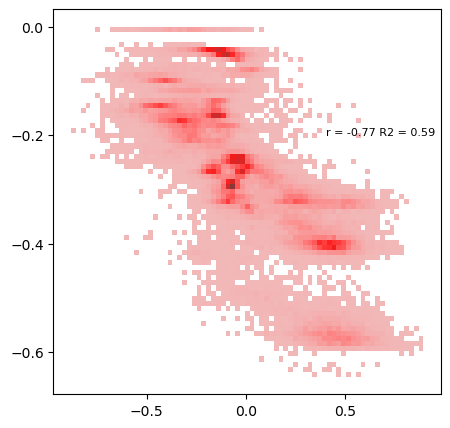

In [14]:
plt.rcParams['svg.fonttype'] = 'none'
task = datasets.ClassificationTaskType.ONE_VS_NINE
ag = '5E94'
fig, ax = plt.subplots(1,1, figsize=(5,5))

df = pd.read_pickle(f"../data/energy_attr_corr/{task.name}_{ag}_energy_attr.pkl")
x_values = np.concatenate(df['attr_aa_norm'].to_numpy())
y_values = np.concatenate(df['energies_total_norm'].to_numpy())
sns.histplot(x = x_values, y = y_values, ax=ax, color='red')
#specify number of thicks
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=7)
r = round(pearsonr(x_values, y_values)[0], 2)
r_sqr = round(r**2,2)
ax.text(0.4, -0.2, f"r = {r} R2 = {r_sqr}", fontsize=8)
plt.savefig(f"./figures/{task.name}_{ag}_per_aa_rule.svg")

### Lets investigate antigens now

# Step 1: Calculate Marginal Frequencies

In [4]:
DATASETS_PATH = config.DATA_BASE_PATH / 'Frozen_MiniAbsolut_ML'

In [5]:
from collections import Counter
def calculate_marginal_frequencies(array):
    positions = array.shape[1]
    marginal_freqs = {}
    for i in range(positions):
        counts = Counter(array[:, i])
        total = len(array)
        marginal_freqs[i] = {aa: count / total for aa, count in counts.items()}
    return marginal_freqs

In [8]:
ag_pos_pwm_entropy = dict()
for i, ag in enumerate(config.ANTIGENS):

    test_path = glob(str(DATASETS_PATH/ f'high_vs_looser/seed_0/split_42/{ag}_high__vs__{ag}_looser/*test_dataset.tsv'))[0]
    df_test = pd.read_csv(test_path, sep='\t')
    df_train_pos = df_test[df_test['y'] == 1]
    seqs = df_train_pos.Slide.values
    marginal_freqs = calculate_marginal_frequencies(np.array([list(seq) for seq in seqs]))

    epsilon = 1e-20
    pwm = pd.DataFrame(marginal_freqs).fillna(0).to_numpy()
    pwm += epsilon
    pwm_norm = pwm / pwm.sum(axis=0)
    
    entropy_matrix = -pwm_norm * np.log2(pwm_norm)
    entropy = entropy_matrix.sum(axis=0)
    total_entropy = entropy.sum()
    ag_pos_pwm_entropy[ag] = total_entropy

In [11]:
task = datasets.ClassificationTaskType.ONE_VS_NINE
ag_r_total_mean = dict()    
for ag in config.ANTIGENS:
    df = pd.read_pickle(f"../data/energy_attr_corr/{task.name}_{ag}_energy_attr.pkl")
    x_values = np.concatenate(df['attr_aa_norm'].to_numpy())
    y_values = np.concatenate(df['energies_total_norm'].to_numpy())
    r_attr_energies = pearsonr(x_values, y_values)[0]
    ag_r_total_mean[ag] = r_attr_energies

In [22]:
df_rule = pd.DataFrame.from_dict(ag_r_total_mean, columns=['r_total'], orient='index')
df_entropy = pd.DataFrame.from_dict(ag_pos_pwm_entropy, columns=['entropy'], orient='index')
df_rule_entropy = df_rule.merge(df_entropy, left_index=True, right_index=True)
df_rule_entropy = df_rule_entropy.reset_index().rename(columns={'index': 'antigen'})

In [25]:
df_rule_entropy

,antigen,r_total,entropy
0,3VRL,-0.637505,30.543936
1,1NSN,0.616000,33.960999
2,3RAJ,-0.661945,36.409785
3,5E94,-0.767844,33.090477
4,1H0D,0.432756,34.857689
5,1WEJ,-0.242451,32.334293
6,1ADQ,0.078353,37.187994
7,1FBI,-0.562789,35.538288
8,2YPV,0.098841,33.536434
9,1OB1,-0.438777,34.571062


Text(0, 0.5, 'Attribution learning')

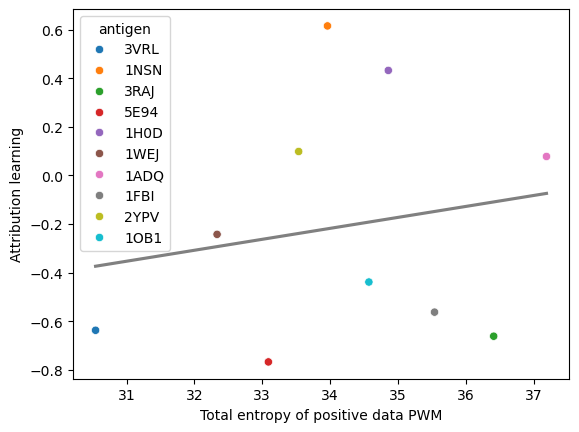

In [26]:
sns.scatterplot(x='entropy', y='r_total', data = df_rule_entropy, hue='antigen')
sns.regplot(x='entropy', y='r_total', data = df_rule_entropy, ci=None,scatter = False, color='grey')
plt.xlabel('Total entropy of positive data PWM')
plt.ylabel('Attribution learning')

In [51]:
energy_attr_slide_r = []
for task in task_types:
    for ag in config.ANTIGENS:
        df_energ_attr = pd.read_pickle(f"../data/energy_attr_corr/{task.name}_{ag}_energy_attr.pkl")
        r_to_plot = df_energ_attr.r_total.median()
        energy_attr_slide_r.append([task.name, ag, r_to_plot])
        

In [52]:
df_energy_attr_slide_r = pd.DataFrame(energy_attr_slide_r, columns=['task', 'Ag', 'per_slide_attr_energy_corr'])

In [53]:
df_energy_attr_slide_r

,task,Ag,per_slide_attr_energy_corr
0,ONE_VS_NINE,3VRL,-0.652054
1,ONE_VS_NINE,1NSN,0.775693
2,ONE_VS_NINE,3RAJ,-0.730530
3,ONE_VS_NINE,5E94,-0.789162
4,ONE_VS_NINE,1H0D,0.512177
5,ONE_VS_NINE,1WEJ,-0.272468
6,ONE_VS_NINE,1ADQ,0.129165
7,ONE_VS_NINE,1FBI,-0.577492
8,ONE_VS_NINE,2YPV,0.117045
9,ONE_VS_NINE,1OB1,-0.465635


<Axes: xlabel='task', ylabel='per_slide_attr_energy_corr'>

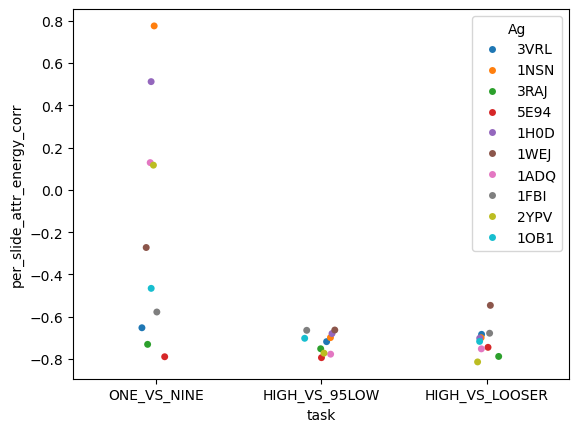

In [56]:
sns.stripplot(x='task', y='per_slide_attr_energy_corr', data = df_energy_attr_slide_r, hue='Ag')

In [153]:
#1ADQ, 2YPV
ag = '1FBI'
paths_to_all_slides = {'1ADQ':[config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1ADQ_AAnalyses/1ADQ_A_500kNonMascotte.txt',
                                config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1ADQ_AAnalyses/1ADQ_A_Looser.txt',
                                config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1ADQ_AAnalyses/1ADQ_A_Heroes.txt'], 
                       '2YPV': [config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/2YPV_AAnalyses/2YPV_A_500kNonMascotte.txt',
                                config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/2YPV_AAnalyses/2YPV_A_Looser.txt',
                                config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/2YPV_AAnalyses/2YPV_A_Heroes.txt'],
                        '1FBI': [config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1FBI_XAnalyses/1FBI_X_500kNonMascotte.txt',
                                 config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1FBI_XAnalyses/1FBI_X_Looser.txt',
                                 config.DATA_BASE_PATH / 'Absolut/data/RawBindingsPerClassMurine/1FBI_XAnalyses/1FBI_X_Heroes.txt']}
def find_seq_2_check(ag):
    task_type = datasets.ClassificationTaskType.ONE_VS_NINE
    task = create_task(task_type, ag)
    vs_9 = loader.load(task, load_model=False, load_test_dataset=True, load_train_dataset=True, load_zscores=False)
    vs_9_train_neg = vs_9.train_dataset.query("y == 0").Slide.values
    vs_9_test_neg = vs_9.test_dataset.query("y == 0").Slide.values
    vs9_seq = set(vs_9_train_neg).union(set(vs_9_test_neg))

    #lets load 1ADQ superheroes and herous
    df_non_mascotte = pd.read_csv(paths_to_all_slides[ag][0], sep='\t', header=1)
    df_looser = pd.read_csv(paths_to_all_slides[ag][1], sep='\t', header=1)
    non_binders_seq = set(df_non_mascotte.Slide.values) & set(df_looser.Slide.values)
    vs9_seq_2_check = vs9_seq.difference(non_binders_seq)

    df_vs9_seq_2_check = pd.DataFrame(vs9_seq_2_check, columns=['Slide']).reset_index()
    df_vs9_seq_2_check.rename(columns={'index': 'ID_slide_Variant'}, inplace=True)
    df_vs9_seq_2_check['CDR3'] = df_vs9_seq_2_check.Slide
    df_vs9_seq_2_check.to_csv(f'{ag}_vs_9_seq_to_check.csv', index=False, sep='\t')



In [152]:
ag = '1ADQ'
find_seq_2_check(ag)

In [154]:
#lets find out binders threashols
def pos_energy_thr(ag):
    task_type = datasets.ClassificationTaskType.ONE_VS_NINE
    task = create_task(task_type, ag)
    vs_9 = loader.load(task, load_model=False, load_test_dataset=True, load_train_dataset=True, load_zscores=False)
    vs_9_train_pos = vs_9.train_dataset.query("y == 1").Slide.values
    vs_9_test_pos = vs_9.test_dataset.query("y == 1").Slide.values
    vs9_seq_pos = set(vs_9_train_pos).union(set(vs_9_test_pos))

    df_heroes = pd.read_csv(paths_to_all_slides[ag][2], sep='\t', header=1)
    max_energy = df_heroes[df_heroes.Slide.isin(vs9_seq_pos)].Energy.max()
    return max_energy

In [203]:
def retrive_energies(ag):
    task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
    task = create_task(task_type, ag)
    df_energy_wk = get_miniabsolut_dataframes(task, load_energy_contributions=True)

    task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
    task = create_task(task_type, ag)
    df_energy_nb = get_miniabsolut_dataframes(task, load_energy_contributions=True)

    weak_energies = df_energy_wk[df_energy_wk['class'] != 'positive'].Energy
    nb_energies = df_energy_nb[df_energy_nb['class'] != 'positive'].Energy
    binder_thr = df_energy_wk[df_energy_wk['class'] == 'positive'].Energy.max()
    return weak_energies, nb_energies, binder_thr

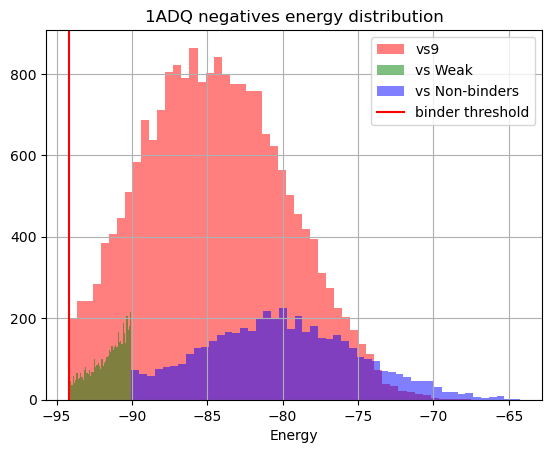

In [208]:
vs9_1adq_res = pd.read_csv(config.DATA_BASE_PATH / '1ADQ_AFinalBindings_Process_1_Of_1.txt', sep='\t', header=1)
vs9_1adq_res.Energy.hist(bins=50, alpha=0.5, color='red', label='vs9')

weak_energies, nb_energies, binder_thr = retrive_energies('1ADQ')
weak_energies.hist(bins=50, color='green', alpha=0.5, label='vs Weak')
nb_energies.hist(bins=50, color='blue', alpha=0.5, label='vs Non-binders')

thr_1adq = pos_energy_thr('1ADQ')
plt.axvline(binder_thr, color='red', label= 'binder threshold')
plt.title('1ADQ negatives energy distribution')
plt.xlabel('Energy')

plt.legend()


In [209]:
vs9_1FBI_res = pd.read_csv(config.DATA_BASE_PATH / '1FBI_XFinalBindings_Process_1_Of_1.txt', sep='\t', header=1)

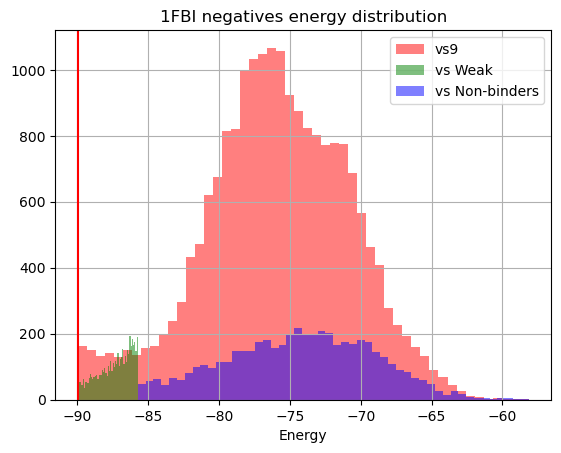

In [241]:
vs9_1FBI_res = pd.read_csv(config.DATA_BASE_PATH / '1FBI_XFinalBindings_Process_1_Of_1.txt', sep='\t', header=1)
vs9_1FBI_res.Energy.hist(bins=50, color='red', alpha=0.5, label='vs9')

weak_energies, nb_energies, binder_thr = retrive_energies('1FBI')
weak_energies.hist(bins=50, color='green', alpha=0.5, label='vs Weak')
nb_energies.hist(bins=50, color='blue', alpha=0.5, label='vs Non-binders')
plt.axvline(binder_thr, color='red')


plt.title('1FBI negatives energy distribution')
plt.xlabel('Energy')

plt.legend()


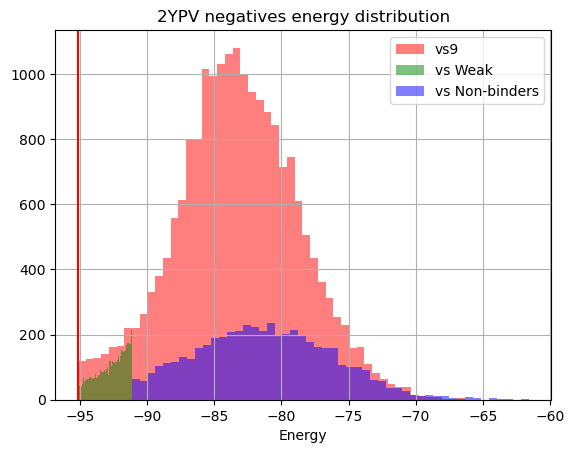

In [242]:
vs9_2YPV_res = pd.read_csv(config.DATA_BASE_PATH / '2YPV_AFinalBindings_Process_1_Of_1.txt', sep='\t', header=1)
vs9_2YPV_res.Energy.hist(bins=50, color='red', alpha=0.5, label='vs9')

weak_energies, nb_energies, binder_thr = retrive_energies('2YPV')
weak_energies.hist(bins=50, color='green', alpha=0.5, label='vs Weak')
nb_energies.hist(bins=50, color='blue', alpha=0.5, label='vs Non-binders')

plt.axvline(binder_thr, color='red')

plt.title('2YPV negatives energy distribution')
plt.xlabel('Energy')

plt.legend()




### Logit Energy rule learning for negative data

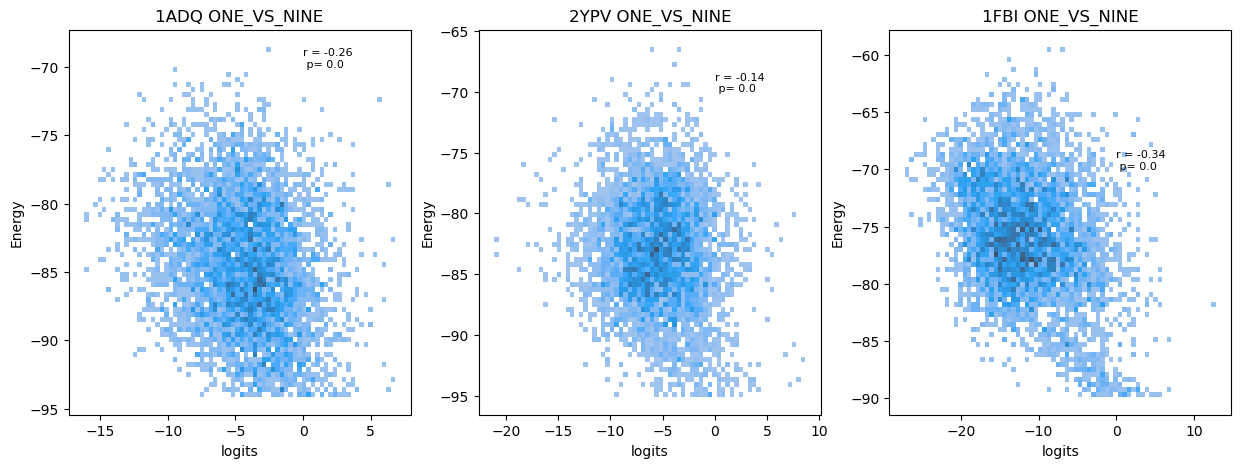

In [240]:
ag_chain = {'1ADQ': 'A', '2YPV': 'A', '1FBI': 'X'}
fig, ax= plt.subplots(1,3, figsize=(15,5))
for i, ag in enumerate(['1ADQ', '2YPV', '1FBI']):
    task_type = datasets.ClassificationTaskType.ONE_VS_NINE
    task = create_task(task_type, ag)
    attr_records =loader.load(task,load_model=False,load_test_dataset=True, load_train_dataset=False,\
        attributions_toload='v2.0-2',attribution_records_toload="attribution_records.json",load_zscores=False,)
    
    df_attr = pd.DataFrame(attr_records.attributions)
    df_attr_neg = df_attr.query("y_true == 0")

    #vs9_1FBI_rule1 = vs9_1FBI_res.merge(df_attr_neg, left_on='Slide', right_on='slide')
    energy_df =  pd.read_csv(config.DATA_BASE_PATH / f'{ag}_{ag_chain[ag]}FinalBindings_Process_1_Of_1.txt', sep='\t', header=1)
    logit_energy_df = energy_df.merge(df_attr_neg, left_on='Slide', right_on='slide')

    r, p = pearsonr(logit_energy_df['logits'], logit_energy_df['Energy'])
    sns.histplot(x='logits', y='Energy', data=logit_energy_df, ax=ax[i], bins=70)
    ax[i].text(0, -70, f"r = {round(r, 2)}\n p= {round(p,2)}", fontsize=8)
    ax[i].set_title(f"{ag} {task_type.name}")



### Are there distracting patterns in vs 9?

In [268]:
from logomaker import Logo
from numpy.linalg import norm
from collections import defaultdict

#fig, ax =  plt.subplots(3,3, figsize=(15,15))
dot_product_pos_neg = defaultdict(dict)
for i, ag in enumerate(['1ADQ', '2YPV', '1FBI']):
    #task_type = datasets.ClassificationTaskType.ONE_VS_NINE
    for j,task_type in enumerate(task_types):
        task = create_task(task_type, ag)
        #load getminiabsolut data
        task_loaded = loader.load(task, load_model=False, load_test_dataset=True, load_train_dataset=True, load_zscores=False)
        neg_seq = task_loaded.train_dataset.query("y == 0").Slide.values
        neg_seq = np.array([list(seq) for seq in neg_seq])
        marginal_freqs_neg = calculate_marginal_frequencies(neg_seq)
        marginal_freqs_neg_df = pd.DataFrame(marginal_freqs_neg).fillna(0).T

        pos_seq = task_loaded.train_dataset.query("y == 1").Slide.values
        pos_seq = np.array([list(seq) for seq in pos_seq])
        marginal_freqs_pos = calculate_marginal_frequencies(pos_seq)
        marginal_freqs_pos_df = pd.DataFrame(marginal_freqs_pos).fillna(0).T

        similarity_matrix = np.dot(marginal_freqs_pos_df.values, marginal_freqs_neg_df.values.T)
        similarity = norm(similarity_matrix)

        dot_product_pos_neg[ag][task_type.name] = similarity

        #plot the logo
        #logo = Logo(marginal_freqs_df, ax=ax[i, j])
        #logo.style_xticks(anchor=0)
        #logo.style_spines(visible=False)
        #logo.ax.set_title(f"{ag} {task_type.name}")



In [269]:
dot_product_pos_neg

defaultdict(dict,
            {'1ADQ': {'ONE_VS_NINE': 1.0245024043639532,
              'HIGH_VS_95LOW': 0.8748076871395872,
              'HIGH_VS_LOOSER': 1.0091987764612376},
             '2YPV': {'ONE_VS_NINE': 1.1095921976833885,
              'HIGH_VS_95LOW': 1.004595090622917,
              'HIGH_VS_LOOSER': 1.1520256035095853},
             '1FBI': {'ONE_VS_NINE': 1.0574802929117022,
              'HIGH_VS_95LOW': 0.9339856746646031,
              'HIGH_VS_LOOSER': 1.0592350876063006}})